# Xception
This workbook is part of the waste image classification project.

This workbook explores the viability of the pretrained Xception model for waste image classification.

In [1]:
import os
import shutil
import pickle

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks, models, layers, losses
from tensorflow.keras.applications import Xception

from azureml.core import Workspace, Dataset, ScriptRunConfig
from azureml.tensorboard import Tensorboard
from azureml.core.environment import Environment

from utils import log_runs, visualize_log, plot_accuracy

# Setup

Load in the resources created in the first notebook, and setup for these expirments

In [2]:
# Load the stored workspace
ws = Workspace.from_config()

In [3]:
# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

In [4]:
## Try with our saved image
env = Environment.get(workspace=ws, name="waste-env-gpu")

In [5]:
# get our compoute cluster
# for cnn we will use a gpu cluster
compute_name = "gpu-cluster-NC6"
compute_target = ws.compute_targets[compute_name]

In [6]:
# set the expiriment
experiment_name = 'xcept'
from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [7]:
script_path = 'xcept_train_script/'

if not os.path.exists(script_path):
    os.mkdir(script_path)

# move the util file to the upload dir
shutil.copy('utils.py', script_path)


'xcept_train_script/utils.py'

# Inspect Xception
Check which layers are missing in the headless version of the model.

In [8]:
xcept = Xception()
xcept.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [9]:
xcept_headless = Xception(include_top=False)
xcept_headless.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

From this comparison we can see that the headless model is missing:
- GlobalAveragePooling2
- predictions (Dense)          

We will add those to the control script for training.

## Write control script

The control script will be uploaded to aml instances in azure.  Images are cached in Azure, so parameterizing the script results in faster run times than submitting new scrips for each run.  It also allows for faster iteration

In [10]:
%%writefile xcept_train_script/train.py

import argparse
import os
import shutil
import numpy as np
import pickle

from azureml.core import Run
from azureml.core import Workspace, Dataset

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array)
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.applications import Xception
from tensorflow.keras import optimizers

from utils import count_files

# set seed for reproducibility
np.random.seed(867)

# output will be logged, separate output from previous log entries.
print('-'*100)

# parse the parameters passed to the this script
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')
    
parser.add_argument('--dense_nodes', 
                    type=str, 
                    dest='dense_nodes', 
                    default='False', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--dense_activations', 
                    type=str, 
                    dest='dense_activations', 
                    default='False', 
                    help='activation function to use on hidden layers (comma separated)')

parser.add_argument('--optimizer', 
                    type=str, 
                    dest='optimizer', 
                    default='sgd', 
                    help='optimizer to use')
parser.add_argument('--epochs', 
                    type=int, 
                    dest='epochs', 
                    default=5, 
                    help='number of epochs to try.')


parser.add_argument('--width_shift_range', 
                    type=float, 
                    dest='width_shift_range', 
                    default=0, 
                    help='ImageGenerator parameter (float)')
parser.add_argument('--height_shift_range', 
                    type=float, 
                    dest='height_shift_range', 
                    default=0, 
                    help='ImageGenerator parameter (float)')
parser.add_argument('--rotation_range', 
                    type=float, 
                    dest='rotation_range', 
                    default=0, 
                    help='ImageGenerator parameter (float)')
parser.add_argument('--brightness_range', 
                    type=str, 
                    dest='brightness_range', 
                    default='1,1', 
                    help='ImageGenerator parameter (float)')
parser.add_argument('--zoom_range', 
                    type=float, 
                    dest='zoom_range', 
                    default=0.0, 
                    help='ImageGenerator parameter (float)')


args = parser.parse_args()

# split list args into lists
if args.dense_nodes != 'False':
    dense_nodes = args.dense_nodes.split(',')
    dense_activations = args.dense_activations.split(',')
    print('Dense Nodes:', dense_nodes)
    print('Dense Activations:', dense_activations)   

# print to log for debuggig if necessary
print('Data folder:',args.data_path)

brightness_range = [float(x) for x in args.brightness_range.split(',')]

# get azure run context
run = Run.get_context()
print('Environment:',run.get_environment().name)


# set data paths
train_folder = os.path.join(args.data_path, 'train')
val_folder = os.path.join(args.data_path, 'validation')
test_folder = os.path.join(args.data_path, 'test')

# count the number of files in each split
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

# print number of files in each split to log
print('Num Train Files:', num_train)
print('Num Val Files:', num_val)
print('Num Test Files:', num_test)


# Create generators for importing the images
print('Creating train ImageDataGenerator')
train_generator = ImageDataGenerator(rescale=1/255,
                                     width_shift_range=args.width_shift_range,
                                     height_shift_range=args.height_shift_range,
                                     rotation_range=args.rotation_range,
                                     brightness_range=brightness_range,
                                     zoom_range=args.zoom_range)\
                        .flow_from_directory(train_folder,
                                             target_size = (244, 244),
                                             batch_size = 32)
print('Creating validation ImageDataGenerator')
val_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(val_folder,
                                             target_size = (244, 244),
                                             batch_size = num_val)
print('Creating test ImageDataGenerator')
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(test_folder,
                                             target_size = (244, 244),
                                             batch_size = num_test)

# model callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=3),
    callbacks.ModelCheckpoint(filepath=f'outputs/{run.id}.h5',
                              save_best_only=True),
    callbacks.TensorBoard(log_dir=f'logs/{run.properties["name"]}/',
                          histogram_freq=1,
                          profile_batch=0)
]

# Import the Xception model
base_model = Xception(
    include_top=False, weights='imagenet',
    input_shape=(244,244,3)
)

# Freeze base_model
base_model.trainable = False

# Build the model
model = models.Sequential()
    
model.add(base_model)

model.add(layers.GlobalAveragePooling2D())

# create hidden layers based on parameters
if args.dense_nodes != 'False':
    for node, activation in zip(dense_nodes, dense_activations):
        print(f'Creating Dense layer with {node} nodes and activation={activation}')
        model.add(layers.Dense(node, activation=activation))

# final layer for classification
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=args.optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# fit model and store history
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=args.epochs,
                    callbacks=my_callbacks)

print('Saving model history...')
with open(f'outputs/{run.id}.history', 'wb') as f:
    pickle.dump(history.history, f)

# print model summary to log
model.summary()

print('evaluating model on test set...')
model_val = model.evaluate(test_generator)

print('Test Loss:', model_val[0])
print('Test Accuracy:', model_val[1])

run.log('test_loss', np.float(model_val[0]))
run.log('test_accuracy', np.float(model_val[1]))

print('Done!')
print('-'*100)

Overwriting xcept_train_script/train.py


# Iterate models

Now that we have a control script we can start submitting runs of various models to azure compute.  They will run asynchronously in parallel which will make this process comparatively fast.

In [11]:
# create var to stor run objects
runs = []

## Model 1
- optimizer: sgd

In [12]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [13]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'xcept-sgd'})

runs[-1].tag('class', 'Xception')
runs[-1].tag('optimizer', 'sgd')


## Model 2
- optimizer: adam

In [14]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--optimizer', 'adam',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [15]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'xcept-adam'})

runs[-1].tag('class', 'Xception')
runs[-1].tag('optimizer', 'adam')

## Start Tensorboard to monitor the runs

In [16]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [17]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

## Evaluate models

In [18]:
# make sure all runs are complete
for run in runs:
    run.wait_for_completion(show_output=False, 
                            wait_post_processing=True, 
                            raise_on_error=True)

In [19]:
log = log_runs(runs, 'xcept')
log

{'test_loss': 0.3134802281856537, 'test_accuracy': 0.9032257795333862}

{'test_loss': 0.27228108048439026, 'test_accuracy': 0.9274193644523621}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
xcept_1615998057_13c1ccdf,xcept-sgd,xcept,00:28:45.124749,0.313480,0.903226,"[1.3444156646728516, 0.9383389949798584, 0.787...","[0.5611795783042908, 0.7341549396514893, 0.774...","[1.0336400270462036, 0.8267647624015808, 0.731...","[0.732824444770813, 0.8015267252922058, 0.7938..."
xcept_1615998062_8d26c458,xcept-adam,xcept,00:11:54.373864,0.272281,0.927419,"[0.928770899772644, 0.5393918752670288, 0.4478...","[0.7064260840415955, 0.8182218074798584, 0.851...","[0.6289923191070557, 0.5730010271072388, 0.498...","[0.7862595319747925, 0.8015267252922058, 0.839..."


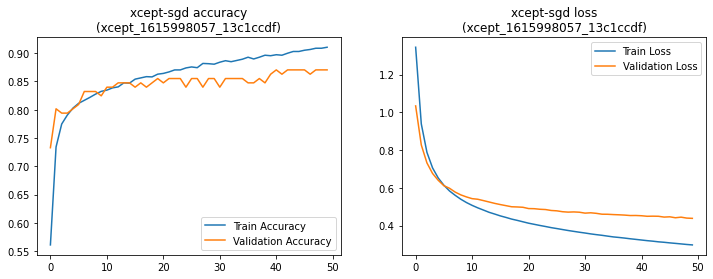

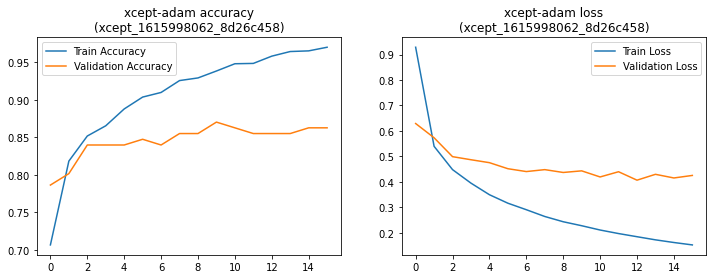

In [20]:
visualize_log(log)

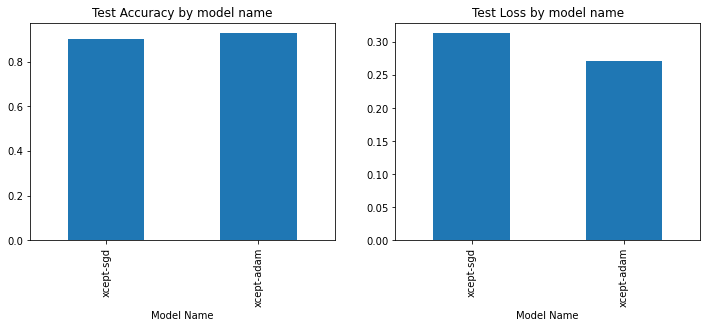

In [21]:
plot_accuracy(log)

The SGD optimizer performed better with nearly 90% accuracy on the test set.  There does appear to be a little bit of over fitting which we will keep an eye on in future iterations.

# Test 1
Add image augmentation

## Model 3
- add image augmentation: shift
- optimizer: sgd

In [22]:
runs2 = []

In [23]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--optimizer', 'adam',
        '--width_shift_range', '0.1',
        '--height_shift_range', '0.1',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [24]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'xcept-shift'})

runs2[-1].tag('class', 'Xception')
runs2[-1].tag('optimizer', 'adam')
runs2[-1].tag('augmentation', 'True')


## Model 4
- add image augmentation: shift
- optimizer: sgd

In [25]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--optimizer', 'adam',
        '--rotation_range', '20',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [26]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'xcept-rotation'})

runs2[-1].tag('class', 'Xception')
runs2[-1].tag('optimizer', 'adam')
runs2[-1].tag('augmentation', 'True')


## Model 5
- add image augmentation: brightness
- optimizer: sgd

In [27]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--optimizer', 'adam',
        '--brightness_range','0.8,1.2',
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [28]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'xcept-brightness'})

runs2[-1].tag('class', 'Xception')
runs2[-1].tag('optimizer', 'adam')
runs2[-1].tag('augmentation', 'True')


## Model 6
- add image augmentation: brightness
- optimizer: sgd

In [29]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--optimizer', 'adam',
        '--zoom_range', 0.1,
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [30]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'xcept-zoom'})

runs2[-1].tag('class', 'Xception')
runs2[-1].tag('optimizer', 'adam')
runs2[-1].tag('augmentation', 'True')


## Start Tensorboard to monitor the runs

In [31]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs2)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [32]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

## Evaluate models

In [33]:
# make sure all runs are complete
for run in runs2:
    run.wait_for_completion(show_output=False, 
                            wait_post_processing=True, 
                            raise_on_error=True)

In [34]:
log = log_runs(runs2, 'xcept')
log

{'test_loss': 0.2664543390274048, 'test_accuracy': 0.9354838728904724}

{'test_loss': 0.2614195942878723, 'test_accuracy': 0.9354838728904724}

{'test_loss': 0.2723970115184784, 'test_accuracy': 0.9354838728904724}

{'test_loss': 0.25157079100608826, 'test_accuracy': 0.9435483813285828}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
xcept_1615998057_13c1ccdf,xcept-sgd,xcept,00:28:45.124749,0.313480,0.903226,"[1.3444156646728516, 0.9383389949798584, 0.787...","[0.5611795783042908, 0.7341549396514893, 0.774...","[1.0336400270462036, 0.8267647624015808, 0.731...","[0.732824444770813, 0.8015267252922058, 0.7938..."
xcept_1615998062_8d26c458,xcept-adam,xcept,00:11:54.373864,0.272281,0.927419,"[0.928770899772644, 0.5393918752670288, 0.4478...","[0.7064260840415955, 0.8182218074798584, 0.851...","[0.6289923191070557, 0.5730010271072388, 0.498...","[0.7862595319747925, 0.8015267252922058, 0.839..."
xcept_1616000143_ab0cf355,xcept-shift,xcept,00:12:43.548203,0.266454,0.935484,"[0.9597858786582947, 0.5754048228263855, 0.477...","[0.6892605423927307, 0.8028169274330139, 0.841...","[0.6559360027313232, 0.5588362216949463, 0.526...","[0.7633587718009949, 0.8244274854660034, 0.824..."
xcept_1616000158_70963c53,xcept-rotation,xcept,00:12:24.404457,0.261420,0.935484,"[0.9399111270904541, 0.5682889223098755, 0.480...","[0.6844190359115601, 0.8089788556098938, 0.841...","[0.6247003078460693, 0.5532976984977722, 0.506...","[0.8091602921485901, 0.847328245639801, 0.8396..."
xcept_1616000161_d0f2d641,xcept-brightness,xcept,00:11:18.432261,0.272397,0.935484,"[0.9299495816230774, 0.5391831994056702, 0.448...","[0.685299277305603, 0.8257042169570923, 0.8560...","[0.630313515663147, 0.5592529773712158, 0.5037...","[0.8015267252922058, 0.8396946787834167, 0.847..."
xcept_1616000165_9e799a90,xcept-zoom,xcept,00:22:10.472872,0.251571,0.943548,"[0.9853468537330627, 0.5710867047309875, 0.474...","[0.6659330725669861, 0.8142605423927307, 0.841...","[0.6369487047195435, 0.5299108624458313, 0.518...","[0.8091602921485901, 0.8320610523223877, 0.832..."


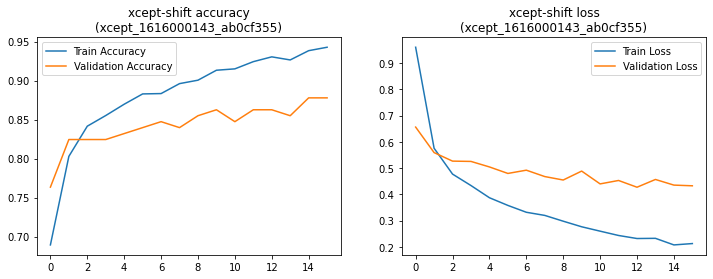

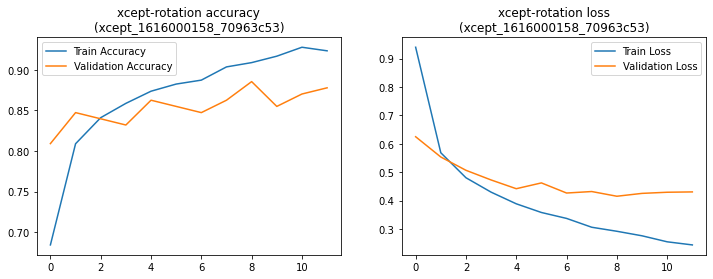

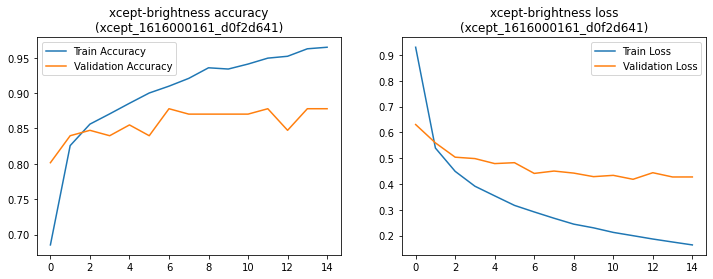

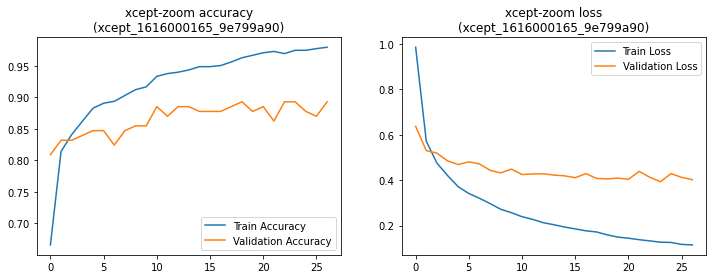

In [35]:
visualize_log(log.loc[[r.id for r in runs2]])

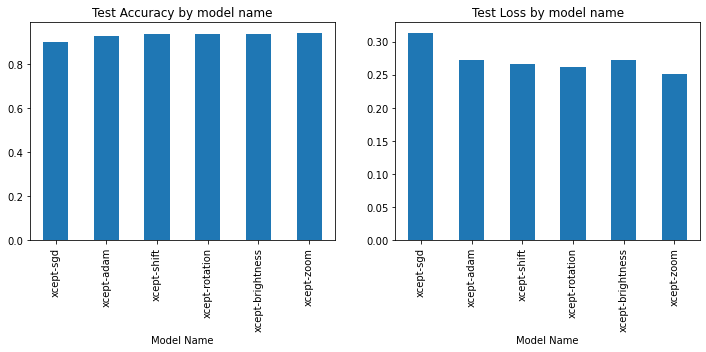

In [36]:
plot_accuracy(log)

# Test 2
Try combining all of the data augmentations

## Model 7
- width_shift
- height_shift
- rotation_range
- brightness_range
- zoom_range
- optimizer: sgd

In [37]:
runs3 = []

In [38]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--optimizer', 'adam',
        '--width_shift_range', '0.2',
        '--height_shift_range', '0.2',
        '--rotation_range', '360',
        '--brightness_range','0.8,1.2',
        '--zoom_range', 0.1,
        '--epochs', '50']

src = ScriptRunConfig(source_directory=script_path,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [39]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'xcept-augment'})

runs3[-1].tag('class', 'Xception')
runs3[-1].tag('optimizer', 'adam')
runs3[-1].tag('augmentation', 'True')


## Start Tensorboard to monitor the runs

In [40]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs3)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [41]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

## Evaluate models

In [42]:
# make sure all runs are complete
for run in runs3:
    run.wait_for_completion(show_output=False, 
                            wait_post_processing=True, 
                            raise_on_error=True)

In [43]:
log = log_runs(runs3, 'xcept')
log

{'test_loss': 0.25972238183021545, 'test_accuracy': 0.9112903475761414}

,name,type,runtime,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
xcept_1615998057_13c1ccdf,xcept-sgd,xcept,00:28:45.124749,0.313480,0.903226,"[1.3444156646728516, 0.9383389949798584, 0.787...","[0.5611795783042908, 0.7341549396514893, 0.774...","[1.0336400270462036, 0.8267647624015808, 0.731...","[0.732824444770813, 0.8015267252922058, 0.7938..."
xcept_1615998062_8d26c458,xcept-adam,xcept,00:11:54.373864,0.272281,0.927419,"[0.928770899772644, 0.5393918752670288, 0.4478...","[0.7064260840415955, 0.8182218074798584, 0.851...","[0.6289923191070557, 0.5730010271072388, 0.498...","[0.7862595319747925, 0.8015267252922058, 0.839..."
xcept_1616000143_ab0cf355,xcept-shift,xcept,00:12:43.548203,0.266454,0.935484,"[0.9597858786582947, 0.5754048228263855, 0.477...","[0.6892605423927307, 0.8028169274330139, 0.841...","[0.6559360027313232, 0.5588362216949463, 0.526...","[0.7633587718009949, 0.8244274854660034, 0.824..."
xcept_1616000158_70963c53,xcept-rotation,xcept,00:12:24.404457,0.261420,0.935484,"[0.9399111270904541, 0.5682889223098755, 0.480...","[0.6844190359115601, 0.8089788556098938, 0.841...","[0.6247003078460693, 0.5532976984977722, 0.506...","[0.8091602921485901, 0.847328245639801, 0.8396..."
xcept_1616000161_d0f2d641,xcept-brightness,xcept,00:11:18.432261,0.272397,0.935484,"[0.9299495816230774, 0.5391831994056702, 0.448...","[0.685299277305603, 0.8257042169570923, 0.8560...","[0.630313515663147, 0.5592529773712158, 0.5037...","[0.8015267252922058, 0.8396946787834167, 0.847..."
xcept_1616000165_9e799a90,xcept-zoom,xcept,00:22:10.472872,0.251571,0.943548,"[0.9853468537330627, 0.5710867047309875, 0.474...","[0.6659330725669861, 0.8142605423927307, 0.841...","[0.6369487047195435, 0.5299108624458313, 0.518...","[0.8091602921485901, 0.8320610523223877, 0.832..."
xcept_1616001686_ccc03fd0,xcept-augment,xcept,00:14:54.856624,0.259722,0.911290,"[1.0351881980895996, 0.6335054636001587, 0.547...","[0.6417253613471985, 0.7794894576072693, 0.801...","[0.6425518989562988, 0.5477928519248962, 0.520...","[0.8167939186096191, 0.8015267252922058, 0.816..."


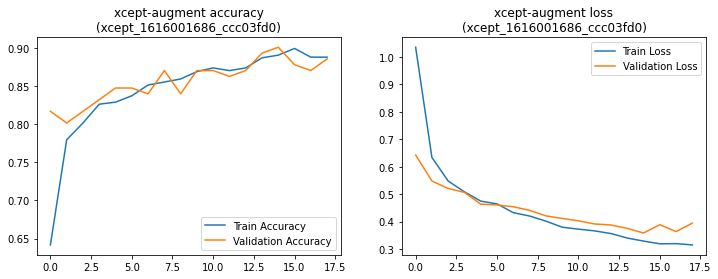

In [45]:
visualize_log(log.loc[[r.id for r in runs3]])

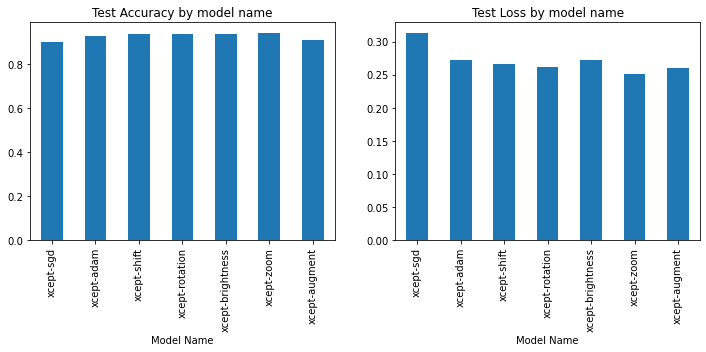

In [46]:
plot_accuracy(log)

Xception with zoom produced our best test accuracy with 94.4% accuracy.  The accuracy plot indicates that the model could be somewhat over fit, but the test results seem to support the accuracy of the validation set.

The final model with more augmentation shows less overfitting and a similar accuracy and loss between the training, validation, and test groups.  Because the size of the test group is rather small the difference between this model's test accuracy and the top performer could be due to chance.  This final model provides good accuracy (91.1%) and doesn't show signs of overfitting.

In the [next notebook](7_Summary_of_Best_Model) we take a look into this model.